For the incoming climate data, we will plot a line chart of air temperature against arrival time. We will also plot a bar chart to visualise the total number of fire records based on each hour. Finally, we will visualise fire locations on a map using markers. We use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, we use a ‘red’ marker

In [ ]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'data'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,40) 
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = json.loads(message.value.decode('utf-8'))
            if data.get('producer') == 1:
                #data = json.loads(message[1])
                x.append(dt.datetime.now().strftime("%M:%S")) 
                y.append(int(data.get('air_temperature_celcius')))
                # print(y)
                # we start plotting only when we have 10 data points
                sleep(8)
            if len(y) > 1:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0,40) 
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
            if len(y)>15:
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

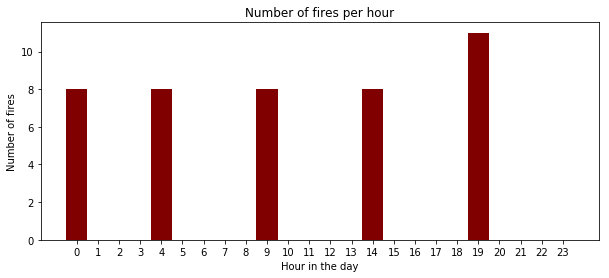

In [44]:
import matplotlib.pyplot as plt # Import appropriate dependencies and libraries
from pymongo import MongoClient
from pprint import pprint

client = MongoClient()
db = client.fit3182_assignment_db
hardquestion = db.hardquestion # Initialise pymongo commands

lst = []
for i in range(24):
    lst.append(0) # Create list of 0s length 24 representing hours

res = hardquestion.aggregate([{'$unwind':'$hotspot_location'}]) # flatten data structure

for doc in res:
    index = int(doc['hotspot_location']['datetime'][12:14]) # slice to get the hour of hotspot
    lst[index]+=1 # count increments by 1
    #pprint(doc)
fig, ax = plt.subplots(figsize = (10,4)) # define dimensions of grpah
number_of_fires = lst # defining y-axis
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23] # defining x-axis
ax.set_xticks(hours) # setting appropriate labels
plt.bar(hours, number_of_fires, color ='maroon', # I like the colour maroon :)
        width = 1)
plt.xlabel('Hour in the day') # labelling appropriately
plt.ylabel("Number of fires")
plt.title('Number of fires per hour')
plt.show()



Task 2: 2b

In [45]:
from pymongo import MongoClient# Import appropriate dependencies
import folium

client = MongoClient()
db = client.fit3182_assignment_db
hardquestion = db.hardquestion
unwinding = db.unwinding # Initialise pymongo commands


#Note: unwond only has documents that have hotspots
res = hardquestion.aggregate([{'$unwind':'$hotspot_location'}]) # unwind and flatten data structure
data_lst = [i for i in res] # length of list is the number of hotspots
m = folium.Map(location= [data_lst[0]['latitude'], data_lst[0]['longitude']], zoom_start=8, tiles="Stamen Terrain") # Follwoing appropriate folium commands
for doc in data_lst: # iterate over number of hotspots
    if doc['hotspot_location']['cause_of_fire'] == "natural": # check if natueral
        folium.Marker( # creating folium marker
        location=[doc['latitude'], doc['longitude']],
        popup= "air temperature: " + str(doc['air_temperature_celcius']) + "\n" + "surface temperature: "+ str(doc['hotspot_location']['surface_temp_avg']) + "\n" + "relative humidity: "+ str(doc["relative_humidity"]) + "\n" + "confidence: " + str(doc["hotspot_location"]["confidence_avg"]), # Pop up on the map
        icon=folium.Icon(color="blue")).add_to(m) # Make marker blue if natural
    else:
        folium.Marker(# creating folium marker
        location=[doc['latitude'], doc['longitude']],
        popup= "air temperature: " + str(doc['air_temperature_celcius']) + "\n " + "surface temperature: "+ str(doc['hotspot_location']['surface_temp_avg']) + "\n" + "relative humidity: "+ str(doc["relative_humidity"]) + "\n" + "confidence: " + str(doc["hotspot_location"]["confidence_avg"]),# Pop up on the map
        icon=folium.Icon(color="red")).add_to(m) # If not natureal, make marker red
    
m # output map
